# Chempy example notebook
##### Credit goes to CHEMPY authors MOST OF THIS NOTEBOOK IS ADAPTED FROM THEIR EXAMPLES 

First we are going to import the chempy package, see the install instructions on the chempy github, and use the "chempy._ _version_" as a sanity check for installing the correct version. Make sure to install the optional dependencies for the chempy package because other useful packages such as thermo,sympy, etc are useful for ode solving, thermodynamic constants, etc. 
__This is to remind myself that I am in the virtual env kittens where I installed chempy__

#### MOST OF THE RATE CONSTANTS VALUES ARE ARBITRARY. will need to ask elizabeth for more clarification, but this notebook is a good start to figuring out the kinetic modelling 

In [1]:
import chempy
import numpy as np
import sympy as sp
sp.init_printing()
import matplotlib.pyplot as plt
%matplotlib inline
sp.__version__, chempy.__version__

('1.4', '0.7.8')

We will first go through an example of balancing stoichiometry and mass fraction calculations that comes with the chempy package

In [2]:
# import classes
from chempy import balance_stoichiometry
from pprint import pprint
from chempy import mass_fractions

In [3]:
reactants, products = balance_stoichiometry({'HCOOH'},{'H2','CO2'})#,'CO','H2O'})

In [4]:
# Creates an ordered dictionary object with the reactants 
reactants

OrderedDict([('HCOOH', 1)])

In [5]:
products

OrderedDict([('CO2', 1), ('H2', 1)])

In [6]:
# Creates a dictionary object with the stoichiometric constants as the items and the reactants as the keys
pprint(dict(reactants))


{'HCOOH': 1}


In [7]:
pprint(dict(products))

{'CO2': 1, 'H2': 1}


In [8]:
mass_fractions

<function chempy.chemistry.mass_fractions(stoichiometries, substances=None, substance_factory=<bound method Substance.from_formula of <class 'chempy.chemistry.Substance'>>)>

In [9]:
# Calculates the weight percents based on the mass 
for fractions in map(mass_fractions, [reactants, products]):
    pprint({k: '{0:.3g} wt%'.format(v*100) for k, v in fractions.items()})
    # .3g is for the number of sig figs 

{'HCOOH': '100 wt%'}
{'CO2': '95.6 wt%', 'H2': '4.38 wt%'}


In [10]:
reaction, product = balance_stoichiometry({'HCOOH'},{'CO','H2O'})
for fractions in map(mass_fractions, [reaction, product]):
    pprint({k: '{0:.3g} wt%'.format(v*100) for k, v in fractions.items()})
    # .4g is for the number of sig figs 

{'HCOOH': '100 wt%'}
{'CO': '60.9 wt%', 'H2O': '39.1 wt%'}


## Reaction Chemical Kinetics 

In [11]:
# Import packages
from chempy import ReactionSystem 
from chempy.kinetics.ode import get_odesys
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

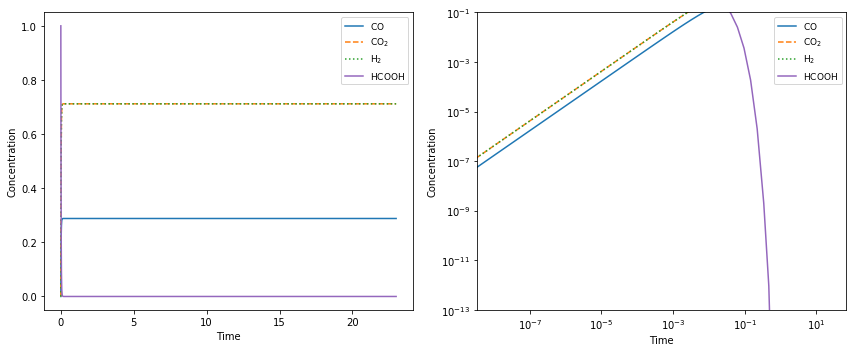

In [12]:
# Reaction System from string 
# The rate constants below are arbitrary
rsys = ReactionSystem.from_string("""
HCOOH -> H2 + CO2; 42
HCOOH -> H2O + CO; 17
""")  # "[H2O]" = 1.0 (actually 55.4 at RT)

# Ordinary Differential Systems of Equations 
odesys, extra = get_odesys(rsys)
# Time axis 
tout = sorted(np.concatenate((np.linspace(0, 23), np.logspace(-8, 1))))
# Initial Concentrations
c0 = defaultdict(float, {'HCOOH': 1.00, 'H2': 0.00, 'CO2': 0.000, 'H2O': 0.00, 'CO': 0.00})
# Integrated ode system 
result = odesys.integrate(tout, c0, atol=1e-12, rtol=1e-14)
# Plotting the results 
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax in axes:
    result.plot(names=[k for k in rsys.substances if k != 'H2O'], ax=ax)
    ax.legend(loc='best', prop={'size': 9})
    ax.set_xlabel('Time')
    ax.set_ylabel('Concentration')
axes[1].set_ylim([1e-13, 1e-1])
axes[1].set_xscale('log')
axes[1].set_yscale('log')
fig.tight_layout()
#fig.savefig('examples/kinetics.png', dpi=72)

In [13]:
rsys

In [14]:
odesys

In [15]:
extra

{'param_keys': [],
 'unique': OrderedDict(),
 'p_units': None,
 'max_euler_step_cb': <function chempy.kinetics.ode.get_odesys.<locals>.max_euler_step_cb(x, y, p=())>,
 'linear_dependencies': <function chempy.kinetics.ode.get_odesys.<locals>.linear_dependencies(preferred=None)>,
 'rate_exprs_cb': <pyodesys.util._Callback at 0x21f64e8bc88>,
 'cstr_fr_fc': False,
 'unit_registry': None}

# Example kinetic model with 2 sets of products 

In [16]:
 # EXAMPLE KINETIC MODEL
from __future__ import absolute_import, division, print_function
from collections import defaultdict
from ipywidgets import interact
import matplotlib.pyplot as plt
from chempy import Reaction, Substance, ReactionSystem
from chempy.kinetics.ode import get_odesys
from chempy.kinetics.analysis import plot_reaction_contributions
from chempy.printing.tables import UnimolecularTable, BimolecularTable
from chempy.util.graph import rsys2graph
import sympy
sympy.init_printing()
%matplotlib inline

In [17]:
# Substance ??
A, B, C, D, E, F= map(Substance, 'ABCDEF')
# Sympy ??
One = sympy.S.One
# Reactions object 
reactions = r0, r1 = [
    Reaction({'A'}, {'B', 'C'}, 4*One/100, name='R1: A cons.'),
    Reaction({'A'}, {'D', 'E'}, 3*One/100, name='R2: A cons.'),
]
# Reaction system 
rsys = ReactionSystem(reactions, (A, B, C, D, E))
# UnimolecularTable and BimolecularTable from Reaction system
uni, not_uni = UnimolecularTable.from_ReactionSystem(rsys)
bi, not_bi = BimolecularTable.from_ReactionSystem(rsys)
assert not (not_uni & not_bi), "There are only uni- & bi-molecular reactions in this set"
# Ordinary Differential Systems of Equations 
odesys, extra = get_odesys(rsys, include_params=True)
odesys.exprs

In [18]:
# Jacobian matrix of Ordinary Differential Systems of Equations 
odesys.get_jac()

⎡-7/100  0  0  0  0⎤
⎢                  ⎥
⎢ 1/25   0  0  0  0⎥
⎢                  ⎥
⎢ 1/25   0  0  0  0⎥
⎢                  ⎥
⎢3/100   0  0  0  0⎥
⎢                  ⎥
⎣3/100   0  0  0  0⎦

In [19]:
reactions

In [20]:
rsys

In [21]:
uni

A,"R1: A cons., R2: A cons."
B,
C,
D,
E,


In [22]:
bi

A,,,,,
B,-,,,,
C,-,-,,,
D,-,-,-,,
E,-,-,-,-,


In [23]:
not_uni

In [24]:
not_bi

In [25]:
# Initial Concentration
c0 = defaultdict(float, {'A': 1})
# Integrated ode system ??
result = odesys.integrate(1e10, c0, integrator='cvode', nsteps=2000)
# Dictionary object ??
{k: v for k, v in result.info.items() if not k.startswith('internal')}

c:\users\user1\anaconda3\envs\kittens\lib\site-packages\pycvodes\_config.py:44: UserWarning: Failed test compilation of '#include <math.h>':
 
  warnings.warn(msg)
c:\users\user1\anaconda3\envs\kittens\lib\site-packages\pycvodes\_config.py:44: UserWarning: Failed to include math.h: 
  warnings.warn(msg)
c:\users\user1\anaconda3\envs\kittens\lib\site-packages\pycvodes\_config.py:44: UserWarning: 
  warnings.warn(msg)
c:\users\user1\anaconda3\envs\kittens\lib\site-packages\pycvodes\_config.py:44: UserWarning: Failed test compilation of '#include <sundials/sundials_config.h>':
 
  warnings.warn(msg)
c:\users\user1\anaconda3\envs\kittens\lib\site-packages\pycvodes\_config.py:44: UserWarning: sundials not in include path, set e.g. $CPLUS_INCLUDE_PATH ():

  warnings.warn(msg)
c:\users\user1\anaconda3\envs\kittens\lib\site-packages\pycvodes\_config.py:44: UserWarning: Failed test compilation of '
    #include <sundials/sundials_config.h>
    #if SUNDIALS_VERSION_MAJOR >= 3
    #include <stdi

{'n_nonlin_solv_iters': 233,
 'n_steps': 186,
 'n_dls_jac_evals': 4,
 'n_nonlin_solv_conv_fails': 0,
 'n_root_evals': 0,
 'n_rhs_evals': 234,
 'n_lin_solv_setups': 48,
 'n_err_test_fails': 8,
 'n_dls_rhs_evals': 0,
 'njvev': 0,
 'nfev': 234,
 'njev': 4,
 'time_cpu': 0.011,
 'time_jtimes': 0.0,
 'time_jac': 0.000191574,
 'time_wall': 0.010793836,
 'time_rhs': 0.010093234000000013,
 'time_prec': 0.0,
 'time_quads': 0.0,
 'time_roots': 0.0,
 'steps': array([], dtype=float64),
 'orders': array([], dtype=int32),
 'fpes': array([], dtype=int32),
 'success': True,
 'atol': [1e-08],
 'rtol': 1e-08,
 'mode': 'adaptive'}

In [26]:
odesys

In [27]:
extra

{'param_keys': [],
 'unique': OrderedDict(),
 'p_units': None,
 'max_euler_step_cb': None,
 'linear_dependencies': None,
 'rate_exprs_cb': <pyodesys.util._Callback at 0x21f6892fa90>,
 'cstr_fr_fc': False,
 'unit_registry': None}

In [28]:
# Experimental rates ??
extra['rate_exprs_cb'](result.xout, result.yout)

array([[ 4.00000000e-02,  3.00000000e-02],
       [ 3.99999791e-02,  2.99999844e-02],
       [ 3.99967271e-02,  2.99975453e-02],
       [ 3.99865668e-02,  2.99899251e-02],
       [ 3.99764087e-02,  2.99823065e-02],
       [ 3.99662532e-02,  2.99746899e-02],
       [ 3.99561001e-02,  2.99670751e-02],
       [ 3.99346578e-02,  2.99509933e-02],
       [ 3.98952558e-02,  2.99214418e-02],
       [ 3.98203854e-02,  2.98652891e-02],
       [ 3.96304666e-02,  2.97228500e-02],
       [ 3.95263476e-02,  2.96447607e-02],
       [ 3.94225021e-02,  2.95668765e-02],
       [ 3.93189294e-02,  2.94891970e-02],
       [ 3.91159337e-02,  2.93369503e-02],
       [ 3.89139863e-02,  2.91854897e-02],
       [ 3.87130818e-02,  2.90348113e-02],
       [ 3.85132147e-02,  2.88849110e-02],
       [ 3.83143795e-02,  2.87357846e-02],
       [ 3.79337531e-02,  2.84503148e-02],
       [ 3.73264129e-02,  2.79948096e-02],
       [ 3.67287969e-02,  2.75465977e-02],
       [ 3.61407485e-02,  2.71055614e-02],
       [ 3.

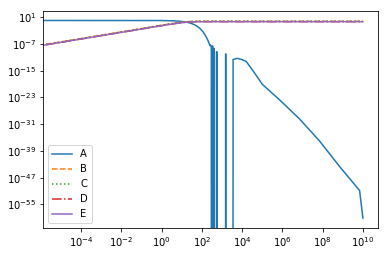

In [29]:
result.plot(xscale='log', yscale='log')

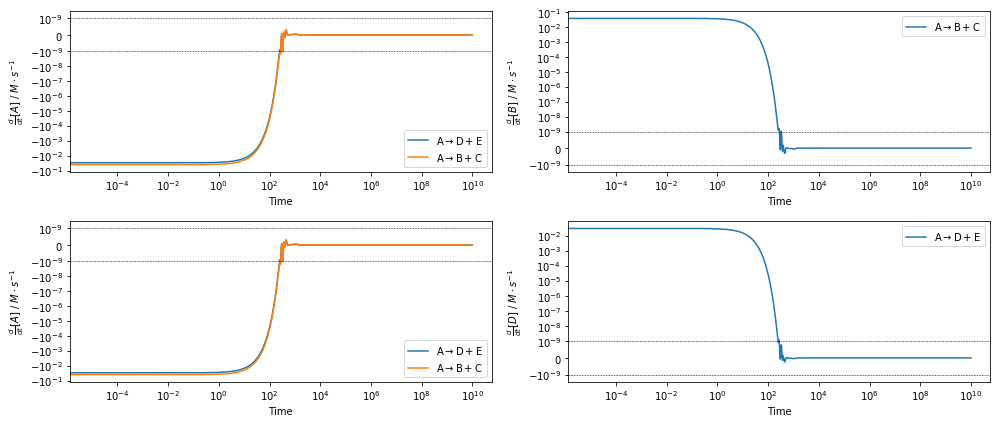

In [30]:
# PLOTTING THE REACTION CONTRIBUTIONS DIRECTLY FROM CHEMPY ROBERTSON
fig, axes = plt.subplots(2, 2, figsize=(14, 6))
# normal y scale
plot_reaction_contributions(result, rsys, extra['rate_exprs_cb'], 'AB', axes=axes[0, :])
plot_reaction_contributions(result, rsys, extra['rate_exprs_cb'], 'AD', axes=axes[1, :])


plt.tight_layout()



c:\users\user1\anaconda3\envs\kittens\lib\site-packages\chempy\kinetics\analysis.py:86: RuntimeWarning: divide by zero encountered in true_divide
  factor = 1/xyp[1][:, rsys.as_substance_index(sk)] if relative else 1


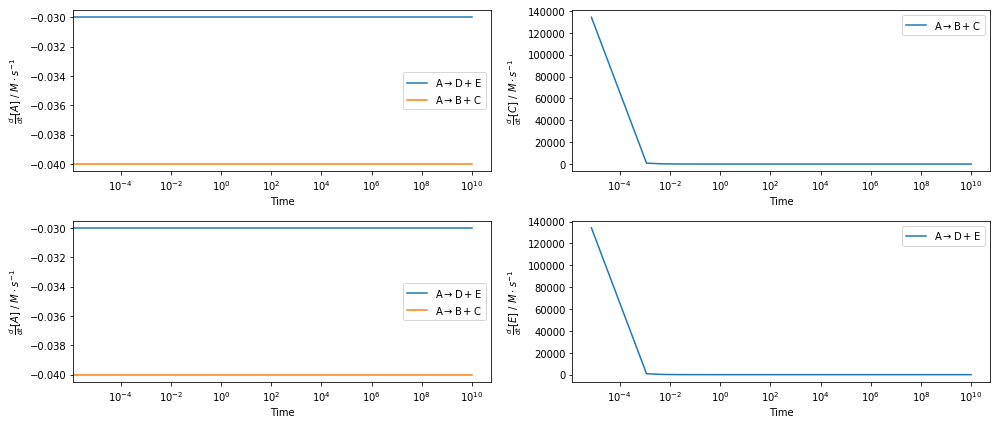

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(14, 6))
# Linear y scale
plot_reaction_contributions(result, rsys, extra['rate_exprs_cb'], 'AC', axes=axes[0, :],
                            relative=True, yscale='linear')
plot_reaction_contributions(result, rsys, extra['rate_exprs_cb'], 'AE', axes=axes[1, :],
                            relative=True, yscale='linear')

plt.tight_layout()


### Now we will incorporate mass action into the kinetic model

In [32]:
str_massaction = """
A -> B + C; 'k1'
A -> D + E; 'k2'
"""

In [33]:
rsys3 = ReactionSystem.from_string(str_massaction, substance_factory=lambda formula: Substance(formula))

In [34]:
str_massaction

"\nA -> B + C; 'k1'\nA -> D + E; 'k2'\n"

In [35]:
rsys3

In [36]:
odesys3, extra3 = get_odesys(rsys3, include_params=False, lower_bounds=[0, 0, 0,0,0])
extra3['param_keys'], extra3['unique']

([], OrderedDict([('k1', None), ('k2', None)]))

In [37]:
odesys3.exprs, odesys3.params, odesys3.names, odesys3.param_names

((-p_0*y_0 - p_1*y_0, p_0*y_0, p_0*y_0, p_1*y_0, p_1*y_0),
 (p_0, p_1),
 ('A', 'B', 'C', 'D', 'E'),
 ('k1', 'k2'))

In [38]:
def integrate_and_plot(A0=1.0, B0=0.0, C0=0.0, D0=0.0, E0=0.0, lg_k1=-2, lg_k2=4, lg_tend=9):
    plt.figure(figsize=(14, 4))
    tout, yout, info = odesys3.integrate(
        10**lg_tend, {'A': A0, 'B': B0, 'C': C0,'D': D0, 'E': E0},
        {'k1': 10**lg_k1, 'k2': 10**lg_k2},
        integrator='cvode', nsteps=3000)
    plt.subplot(1, 2, 1)
    odesys3.plot_result(xscale='log', yscale='log')
    plt.legend(loc='best')
    plt.subplot(1, 2, 2)
    plt.plot(tout[tout<.05], yout[tout<.05, odesys3.names.index('B')])
    _ = plt.legend('best')
interact(integrate_and_plot) #, **kw) 
# kw for additional optional arguments 

interactive(children=(FloatSlider(value=1.0, description='A0', max=3.0, min=-1.0), FloatSlider(value=0.0, desc…

<function __main__.integrate_and_plot(A0=1.0, B0=0.0, C0=0.0, D0=0.0, E0=0.0, lg_k1=-2, lg_k2=4, lg_tend=9)>

In [39]:
# We could also have used SymPy to construct symbolic rates:
import sympy
rsys_sym = ReactionSystem.from_string("""
A -> B + C; sp.Symbol('k1')
A -> D + E; sp.Symbol('k2')
""", rxn_parse_kwargs=dict(globals_={'sp': sympy}), substance_factory=lambda formula: Substance(formula))
odesys_sym, _ = get_odesys(rsys_sym, params=True)
for attr in 'exprs params names param_names'.split():
    print(getattr(odesys_sym, attr))

(-k1*y_0 - k2*y_0, k1*y_0, k1*y_0, k2*y_0, k2*y_0)
(k1, k2)
('A', 'B', 'C', 'D', 'E')
()


For larger systems it is easy to loose track of what substances are actually playing a part, here the html tables can help (note the yellow background color):

In [40]:
rsys.substances['F'] = F
uni, not_uni = UnimolecularTable.from_ReactionSystem(rsys)
uni

A,"R1: A cons., R2: A cons."
B,
C,
D,
E,
F,


In [41]:
bi, not_bi = BimolecularTable.from_ReactionSystem(rsys)
bi

A,,,,,,
B,-,,,,,
C,-,-,,,,
D,-,-,-,,,
E,-,-,-,-,,
F,-,-,-,-,-,


In [42]:
# # Saving a Picture 
# rsys2graph(rsys, 'pciture.png', save='.')
# from IPython.display import Image; Image('picture.png')

# Arrhenius Kinetic model with 2 sets of products

In [43]:
from collections import defaultdict
from itertools import chain
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from ipywidgets import interact
from chempy import Substance, Reaction, ReactionSystem
from chempy.kinetics.rates import Arrhenius, MassAction
from chempy.kinetics.ode import get_odesys
from chempy.printing.numbers import number_to_scientific_latex
from chempy.units import SI_base_registry, default_units as u
sp.init_printing()
%matplotlib inline

In [44]:
A, B, C, D, E, F= map(Substance, 'ABCDEF')
r1 = Reaction({'A'}, {'B','C'}, MassAction(Arrhenius(unique_keys=('A1', 'Ea_R_1'))))
r2 = Reaction({'A'}, {'D','E'}, MassAction(Arrhenius(unique_keys=('A2', 'Ea_R_2'))))
rsys = ReactionSystem([r1, r2])
rsys

In [45]:
# Temperature is at 15 C just like the calibration
# Activation energies and rates are arbitrary
params = {'A1': 1e11/u.s, 'A2': 2e11/u.s, 'Ea_R_1': 8e3*u.K, 'Ea_R_2': 8.5e3*u.K, 'temperature': 288*u.K}
c0 = defaultdict(lambda: 0*u.molar, {'A': 1*u.molar})
variables = c0.copy()
variables.update(params)
rsys.rates(variables)

{'C': array(0.08635041) * M/s,
 'A': array(-0.11678104) * M/s,
 'B': array(0.08635041) * M/s,
 'E': array(0.03043063) * M/s,
 'D': array(0.03043063) * M/s}

In [46]:
odesys, extra = get_odesys(rsys, include_params=False, lower_bounds=0)
print(dict(zip(odesys.dep, odesys.names)))
print(dict(zip(odesys.params, odesys.param_names)))
odesys.exprs

{y_0: 'A', y_1: 'B', y_2: 'C', y_3: 'D', y_4: 'E'}
{p_0: 'temperature', p_1: 'A1', p_2: 'Ea_R_1', p_3: 'A2', p_4: 'Ea_R_2'}


In [47]:
params2 = params.copy()
pk = 'Ea_R_2'
params2[pk] = [(320+273), (340+273), (360+273)]*u.K

In [48]:
params2

{'A1': array(1.e+11) * 1/s,
 'A2': array(2.e+11) * 1/s,
 'Ea_R_1': array(8000.) * K,
 'Ea_R_2': array([593., 613., 633.]) * K,
 'temperature': array(288.) * K}

In [49]:
params2[pk]

array([593., 613., 633.]) * K

# Run time errors happen for 1 second or over for arrhenius model

# Will need to fix 

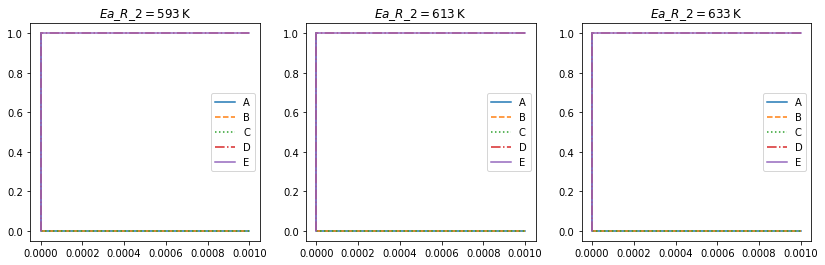

In [50]:
res2 = odesys.integrate(.001*u.s, c0, params2, integrator='cvode')
# plotting at the 3 temperatures 
fig, axes = plt.subplots(1, len(res2), figsize=(14, 4))
for r, ax in zip(res2, axes):
    r.plot(ax=ax)
    ax.set_title('$%s = %s$' % (pk.replace('_', '\\_'), number_to_scientific_latex(r.named_param('Ea_R_2'))))


Using ipywidgets to get interactive controls:

In [51]:
def integrate_and_plot(T_C=25):
    res = odesys.integrate(7*u.s, c0, dict(params, temperature=(T_C+273.15)*u.K), integrator='cvode')
    res.plot()
interact(integrate_and_plot)

interactive(children=(IntSlider(value=25, description='T_C', max=75, min=-25), Output()), _dom_classes=('widge…

<function __main__.integrate_and_plot(T_C=25)>